In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # 훈련셋과 테스트셋을 분리
from tensorflow.keras.models import Sequential # 모델생성
from tensorflow.keras.layers import Dense, Dropout # Dense(모델layer), Dropout(과적합 줄이기)
import matplotlib.pyplot as plt
from tensorflow.keras import metrics # 성능지표들

- 심장병 발병 예측
```
1. 데이터 셋 생성 & 전처리
    엑셀데이터 -> ?를 nan -> nan 처리 -> X, y 분리 -> 훈련셋과 테스트셋분리(api이용)
2. 모델 생성 & 구성(과적합 줄이기 단계 추가)
3. 모델 학습과정설정 (accuracy, precision, recall)
4. 모델 학습시키기 (훈련셋의 일부를 검증셋으로 학습)
5. 모델 평가 - 과정살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)
6. 모델 사용하기
```

## 1. 데이터 셋 생성 & 전처리
- 엑셀데이터 -> ?를 nan -> nan 처리 -> X, y 분리 -> 훈련셋과 테스트셋분리(api이용)

In [10]:
raw_data = pd.read_excel('./data/heart-disease.xlsx')
raw_data.head(3)

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [12]:
# raw_data의 타입이 object인 열에 ?가 있는 데이터 추출
raw_data[(raw_data['chol']=='?') | (raw_data['ca']=='?') | (raw_data['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [13]:
# '?'를 결측치(np.nan)로 대체
clean_data = raw_data.replace('?', np.nan)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [14]:
# clean_data에 결측치가 포함된 데이터 추출
clean_data[clean_data.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [15]:
# 결측치를 중앙값으로 대체
# 열별 중앙값 : clean_data.median(axis=0) - axis=0는 기본값이므로 생략 가능
clean_data.fillna(value=clean_data.median())

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,241.5,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.0,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193.0,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131.0,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236.0,0,2,174,0,0.0,2,1.0,3.0,1


In [16]:
# 결측치가 하나라도 있는 행은 제거
clean_data.dropna(how='any', inplace=True)
clean_data.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [17]:
clean_data.head()

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236.0,0,0,178,0,0.8,1,0.0,3.0,0


In [18]:
# 독립변수(입력변수, X), 종속변수(타겟변수, y)
Input = clean_data.iloc[:, :-1]
Target = clean_data.iloc[:,-1:]
Target = clean_data.iloc[:,[-1]]
Input.shape, Target.shape

((296, 13), (296, 1))

In [19]:
# 전체 296개 데이터 중 심장병이 걸린 데이터 수(1)
Target['heartDisease'].sum()

136

In [20]:
# 심장병이 걸린 데이터 확률
Target['heartDisease'].mean()

0.4594594594594595

In [21]:
# unique 별 데이터 갯수
Target['heartDisease'].value_counts()

0    160
1    136
Name: heartDisease, dtype: int64

In [22]:
# sclae 조정(Input 데이터만)
scaler = MinMaxScaler()
scaled_input = pd.DataFrame(scaler.fit_transform(Input))
print(Input.shape, scaled_input.shape)
scaled_input.head(2)

(296, 13) (296, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.708333,1.0,0.0,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.0,0.75
1,0.791667,1.0,1.0,0.622642,0.365297,0.0,0.0,0.282443,1.0,0.241935,0.5,1.0,0.00


In [23]:
# scaled_input와 Target => 학습셋(=훈련셋,train set):시험셋(=test set) = 7:3
X_train, X_test, y_train, y_test =train_test_split(scaled_input, #입력변수(독립변수)
                 Target, # 타겟변수(종속변수)
                 test_size=0.3, # 시험셋 사이즈가 지정되면 학습셋은 자동 지정
                 random_state=42 # random seed값
                )

## 2. 모델 생성 & 구성(과적합 줄이기 단계 추가)

In [24]:
model = Sequential()
model.add(Dense(units=500, input_dim=13, activation='relu'))
# 과적합을 해결하고자 dropout(두루뭉실하게 출력)
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='tanh'))
model.add(Dropout(0.1))
 # 출력층에서의 활성화 함수 : 이진분류(로지스틱회귀)에서는 sigmoid, 분류분석에서는 softmax
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               7000      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

## 3. 모델 학습과정설정 (accuracy, precision, recall)

In [25]:
# 분류분석일 때, 성능평가지표
# accuracy(정확도) : 예측결과와 실제값이 동일한 건수 / 전체건수
# precision(정밀도, 민감도) : 실제도 True인데 예측도 True로 맞춘 건수 / True로 예측한 건수
# recall(재현율) : 실제 True인데 예측도 True로 맞춘 건수 / 실제가 True인 건수
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',metrics.Recall(), metrics.Precision()])

## 4. 모델 학습시키기 (훈련셋의 일부를 검증셋으로 학습)

In [26]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=1, 
       validation_split=0.2 # 훈련데이터 셋의 20%를 검증데이터셋으로
       )

Epoch 1/100
2/2 [==============================] - 2s 420ms/step - loss: 0.6876 - accuracy: 0.5212 - recall: 0.4805 - precision: 0.4868 - val_loss: 0.6184 - val_accuracy: 0.6667 - val_recall: 0.9474 - val_precision: 0.5806
Epoch 2/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6179 - accuracy: 0.7091 - recall: 0.9481 - precision: 0.6239 - val_loss: 0.5418 - val_accuracy: 0.8333 - val_recall: 0.8421 - val_precision: 0.8000
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 0.5487 - accuracy: 0.8121 - recall: 0.8312 - precision: 0.7805 - val_loss: 0.4742 - val_accuracy: 0.7857 - val_recall: 0.6842 - val_precision: 0.8125
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 0.4960 - accuracy: 0.8121 - recall: 0.7792 - precision: 0.8108 - val_loss: 0.4243 - val_accuracy: 0.7857 - val_recall: 0.6842 - val_precision: 0.8125
Epoch 5/100
2/2 [==============================] - 0s 44ms/step - loss: 0.4583 - accuracy: 0.8182 - recall: 0.7

Epoch 38/100
2/2 [==============================] - 0s 35ms/step - loss: 0.1588 - accuracy: 0.9273 - recall: 0.9091 - precision: 0.9333 - val_loss: 0.5294 - val_accuracy: 0.8333 - val_recall: 0.7895 - val_precision: 0.8333
Epoch 39/100
2/2 [==============================] - 0s 35ms/step - loss: 0.1441 - accuracy: 0.9515 - recall: 0.9740 - precision: 0.9259 - val_loss: 0.5584 - val_accuracy: 0.8333 - val_recall: 0.7895 - val_precision: 0.8333
Epoch 40/100
2/2 [==============================] - 0s 38ms/step - loss: 0.1540 - accuracy: 0.9273 - recall: 0.9351 - precision: 0.9114 - val_loss: 0.5835 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 41/100
2/2 [==============================] - 0s 37ms/step - loss: 0.1484 - accuracy: 0.9515 - recall: 0.9351 - precision: 0.9600 - val_loss: 0.5950 - val_accuracy: 0.8810 - val_recall: 0.7895 - val_precision: 0.9375
Epoch 42/100
2/2 [==============================] - 0s 59ms/step - loss: 0.1295 - accuracy: 0.9455 - recall:

Epoch 75/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0437 - accuracy: 0.9879 - recall: 1.0000 - precision: 0.9747 - val_loss: 1.2194 - val_accuracy: 0.8571 - val_recall: 0.7368 - val_precision: 0.9333
Epoch 76/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0414 - accuracy: 0.9758 - recall: 0.9481 - precision: 1.0000 - val_loss: 1.1986 - val_accuracy: 0.8571 - val_recall: 0.7368 - val_precision: 0.9333
Epoch 77/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0389 - accuracy: 0.9879 - recall: 1.0000 - precision: 0.9747 - val_loss: 1.2120 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 78/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0374 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.2642 - val_accuracy: 0.8571 - val_recall: 0.7368 - val_precision: 0.9333
Epoch 79/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0283 - accuracy: 0.9939 - recall:

## 5. 모델 평가
- 과정살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)

In [27]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

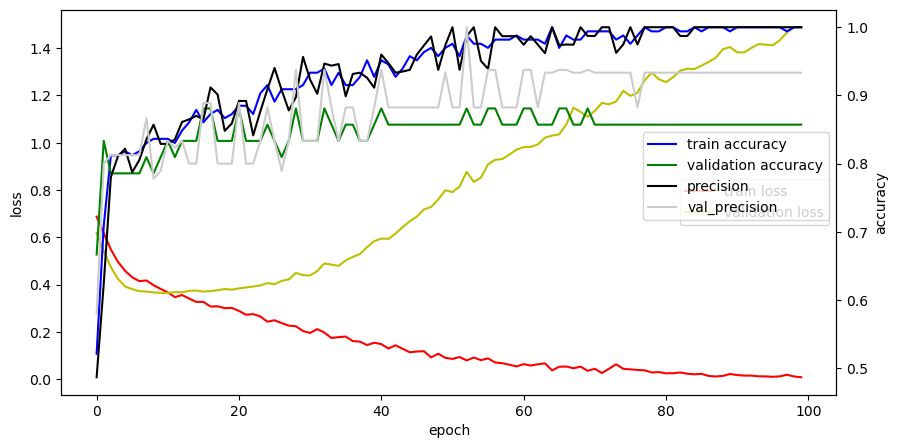

In [29]:
# 모델 평가
score = model.evaluate(X_test, y_test)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model recall :', score[2])
print('model precision :', score[3])

3/3 [==============================] - 0s 2ms/step - loss: 1.0866 - accuracy: 0.8202 - recall: 0.8000 - precision: 0.8000
model loss : 1.0865709781646729
model accuracy : 0.8202247023582458
model recall : 0.800000011920929
model precision : 0.800000011920929


In [30]:
# confusion matrix (매개변수에 2차원 데이터)
y_hat = (model.predict(X_test)>0.5).astype(int)
print(y_hat.shape)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
print(confusion_matrix(y_test, y_hat))
print('f1 score :', f1_score(y_test, y_hat))

3/3 [==============================] - 0s 3ms/step
(89, 1)
[[41  8]
 [ 8 32]]
f1 score : 0.8000000000000002


In [31]:
# crosstab (매개변수에 1차원 데이터)
pd.crosstab(y_test.values.reshape(-1), # 실제값(1차원)
           y_hat.reshape(-1) )  # 예측값(1차원)

col_0,0,1
row_0,,
0,41,8
1,8,32


## 6. 모델 사용하기